In [1]:
from matplotlib import pyplot
from matplotlib.image import imread
import pandas as pd
import numpy as np
import sys
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from sklearn.model_selection import train_test_split
from keras.layers import Dropout

from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import fbeta_score

Using TensorFlow backend.


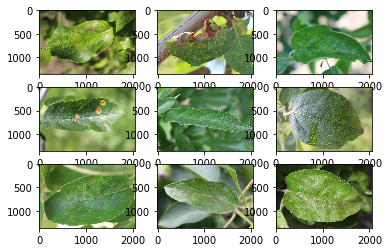

In [2]:
# plot the first 9 images in the plant dataset
# define location of dataset

folder = 'train-img/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'train_' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [3]:
# load and summarize the mapping file for the plant dataset
from pandas import read_csv
# load file as CSV
filename = 'train.csv'
mapping_csv = read_csv(filename)
# summarize properties
print(mapping_csv.shape)
print(mapping_csv[:10])

(1821, 5)
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
5  Train_5        1                  0     0     0
6  Train_6        0                  1     0     0
7  Train_7        0                  0     0     1
8  Train_8        0                  0     0     1
9  Train_9        1                  0     0     0


In [4]:
# create a mapping of labels to integers

labels_map = {'healthy' : 1, 'multiple_diseases': 2, 'rust' : 3, 'scab' : 4}
inv_labels_map = {1 : 'healthy', 2 : 'multiple_diseases', 3: 'rust', 4: 'scab'}
    


In [5]:
label_list = []
def map_label_to_integer(label_name):
    label_list.append(labels_map[label_name]) 
    

In [6]:

for i in range(len(mapping_csv)):
    if( mapping_csv['healthy'][i] == 1 ):
        map_label_to_integer('healthy')
    elif ( mapping_csv['multiple_diseases'][i]== 1 ):
        map_label_to_integer('multiple_diseases')
    elif ( mapping_csv['rust'][i] == 1 ):
        map_label_to_integer('rust')
    else:
        map_label_to_integer('scab')
      

In [7]:
img_label = pd.Series([]) 
for i in range(len(mapping_csv)):
    img_label[i] = label_list[i]
mapping_csv.insert(5, "img_label", img_label) 

In [8]:
mapping_csv.head()


,image_id,healthy,multiple_diseases,rust,scab,img_label
0,Train_0,0,0,0,1,4
1,Train_1,0,1,0,0,2
2,Train_2,1,0,0,0,1
3,Train_3,0,0,1,0,3
4,Train_4,1,0,0,0,1


In [9]:
#Similarly mapping_csv_test
mapping_csv_test = read_csv("test.csv")
print(mapping_csv_test.head())


  image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4


In [10]:
# create a mapping of filename to label's integer value
### --- not used
def create_file_mapping(mapping_csv):
    mapping = dict()
    for i in range(len(mapping_csv)):
        try:
            name ,mapping[name] = mapping_csv['image_id'][i], inv_labels_map[mapping_csv['img_label'][i]]
            
        except KeyError:
            print("The key does not exist!")    
    return mapping 
    


In [11]:
#create_file_mapping(mapping_csv)

In [11]:
## create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
    # create empty vector
    encoding = zeros(len(mapping), dtype='uint8')
    # mark 1 for each tag in the vector
    #for tag in tags:
    encoding[mapping[tags] -1 ] = 1
    return encoding

In [12]:
# load all images into memory
def load_dataset(path, file_mapping, tag_mapping):
    photos, targets = list(), list()
    # enumerate files in the directory
    for filename in listdir(folder):
    #for i in range(3):
        #filename = 'Train_' + str(i) + '.jpg'
        # load image
        photo = load_img(path + filename, target_size=(128,128))
        # convert to numpy array
        photo = img_to_array(photo, dtype='uint8')
        # get tags
        tags = file_mapping[filename[:-4]]
        # one hot encode tags
        target = one_hot_encode(tags,tag_mapping)
        # store
        photos.append(photo)
        targets.append(target)
    X = asarray(photos, dtype='uint8')
    y = asarray(targets, dtype='uint8')
    
    return X, y

In [14]:
# load the mapping file
#### ---- Takes time RUN ONLY ONCE to CREATE  plant_data.npz FILE-----

# create a mapping of tags to integers
#tag_mapping = labels_map


# create a mapping of filenames to tag's integer lists --> 'Train_0': 'scab',
#file_mapping = create_file_mapping(mapping_csv)

#print(file_mapping)
# load the jpeg images
#folder = 'train-img/'

# load dataset
#X,y = load_dataset(folder, file_mapping, tag_mapping)
#print(X.shape, y.shape)

# save both arrays to one file in compressed format
#savez_compressed('plant_data.npz', X, y)

In [13]:
# separate into train and test datasets
def load_data():
    # load prepared planet dataset
    from numpy import load
    data = load('plant_data.npz')
    X, y = data['arr_0'], data['arr_1']
    print('Loaded: ', X.shape, y.shape)
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1)
    print("train_x,test_x,train_y,test_y")
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, testX, trainY, testY

#load_data()

In [14]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

In [16]:
# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=4):
    model = Sequential()
    #model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    #model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    #model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=in_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(out_shape, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    #check keras metrics to check for custom made metrics
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[fbeta])
   
    return model

In [17]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [23]:
# run the test harness for evaluating a model

def run_test_harness():
    # load dataset
    trainX,  testX, trainY, testY = load_data()
    #----Without Image Augmentation-----
    # create data generator
    #datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    #train_it = datagen.flow(trainX, trainY, batch_size=128)
    #test_it = datagen.flow(testX, testY, batch_size=128)
    
    #----With Image Augmentation-----
    # create data generator
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = train_datagen.flow(trainX, trainY, batch_size=128)
    test_it = test_datagen.flow(testX, testY, batch_size=128)
    
    # define model
    model = define_model()
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(test_it), epochs=200, verbose=1)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # save model and architecture to single file
    model.save("model.h5")
    print("Saved model to disk")
    # learning curves
    summarize_diagnostics(history)
    

In [24]:
# entry point, run the test harness
# ---Note--- val_accuracy - is the acc of the model on validation set / acc- acc on training set
# val_acc < acc ----> over fitting
run_test_harness()

Loaded:  (1821, 128, 128, 3) (1821, 4)
train_x,test_x,train_y,test_y
(1456, 128, 128, 3) (1456, 4) (365, 128, 128, 3) (365, 4)
Epoch 1/200
12/12 [==============================] - 258s 22s/step - loss: 2.2052 - fbeta: 0.0812 - val_loss: 1.3141 - val_fbeta: 0.0000e+00
Epoch 2/200
12/12 [==============================] - 191s 16s/step - loss: 1.3078 - fbeta: 0.0449 - val_loss: 1.2411 - val_fbeta: 0.0000e+00
Epoch 3/200
12/12 [==============================] - 186s 16s/step - loss: 1.2537 - fbeta: 6.5104e-04 - val_loss: 1.3159 - val_fbeta: 0.0000e+00
Epoch 4/200
12/12 [==============================] - 199s 17s/step - loss: 1.2506 - fbeta: 0.0000e+00 - val_loss: 1.2603 - val_fbeta: 0.0000e+00
Epoch 5/200
12/12 [==============================] - 177s 15s/step - loss: 1.2502 - fbeta: 0.0033 - val_loss: 1.2988 - val_fbeta: 0.0000e+00
Epoch 6/200
12/12 [==============================] - 175s 15s/step - loss: 1.2452 - fbeta: 0.0000e+00 - val_loss: 1.2739 - val_fbeta: 0.0000e+00
Epoch 7/200
12/

12/12 [==============================] - 312s 26s/step - loss: 0.6938 - fbeta: 0.6565 - val_loss: 0.6262 - val_fbeta: 0.6725
Epoch 118/200
12/12 [==============================] - 312s 26s/step - loss: 0.6638 - fbeta: 0.6625 - val_loss: 0.6054 - val_fbeta: 0.6790
Epoch 119/200
12/12 [==============================] - 317s 26s/step - loss: 0.6713 - fbeta: 0.6656 - val_loss: 0.7138 - val_fbeta: 0.7020
Epoch 120/200
12/12 [==============================] - 316s 26s/step - loss: 0.6597 - fbeta: 0.7059 - val_loss: 0.6538 - val_fbeta: 0.6290
Epoch 121/200
12/12 [==============================] - 315s 26s/step - loss: 0.6567 - fbeta: 0.6669 - val_loss: 0.6342 - val_fbeta: 0.7116
Epoch 122/200
12/12 [==============================] - 319s 27s/step - loss: 0.6265 - fbeta: 0.7112 - val_loss: 0.6673 - val_fbeta: 0.7046
Epoch 123/200
12/12 [==============================] - 313s 26s/step - loss: 0.6227 - fbeta: 0.7216 - val_loss: 0.5827 - val_fbeta: 0.7082
Epoch 124/200
12/12 [====================

12/12 [==============================] - 150s 13s/step - loss: 0.3288 - fbeta: 0.8845 - val_loss: 0.5376 - val_fbeta: 0.8416
Epoch 177/200
12/12 [==============================] - 150s 13s/step - loss: 0.3376 - fbeta: 0.8785 - val_loss: 0.5443 - val_fbeta: 0.7969
Epoch 178/200
12/12 [==============================] - 149s 12s/step - loss: 0.3642 - fbeta: 0.8620 - val_loss: 0.4245 - val_fbeta: 0.8791
Epoch 179/200
12/12 [==============================] - 150s 12s/step - loss: 0.3545 - fbeta: 0.8674 - val_loss: 0.4920 - val_fbeta: 0.8299
Epoch 180/200
12/12 [==============================] - 151s 13s/step - loss: 0.3678 - fbeta: 0.8648 - val_loss: 0.3054 - val_fbeta: 0.8509
Epoch 181/200
12/12 [==============================] - 154s 13s/step - loss: 0.3234 - fbeta: 0.8809 - val_loss: 0.2920 - val_fbeta: 0.8934
Epoch 182/200
12/12 [==============================] - 150s 12s/step - loss: 0.3392 - fbeta: 0.8713 - val_loss: 0.4024 - val_fbeta: 0.8895
Epoch 183/200
12/12 [====================